<a href="https://colab.research.google.com/github/Code-By-Pitt/Capstone3/blob/main/Capstone_3_Preprocessing_%26_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Only necessary to run this cell once
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,callbacks,metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM,Bidirectional
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("/content/gdrive/MyDrive/Springboard/Captsone 3/DataFiles/Cap3_cleaned_daily_data.csv",parse_dates=['Day'])

# Data Preprocessing

This includes

*   Build data with key features
*   Prepare data for use with neural network. This includes scaling, transforming and restructuring data.



In [4]:
#Specify features to use
df.sort_values(by=['Day'])
cols = ['Clicks',
 'Impr.',
 'Cost',
 'Conv. value',
 'Store Visits',
 'Store Revenue',
 'Conversions','dayName','Quarter2','year']

In [5]:
train_dates = pd.to_datetime(df['Day'])

In [6]:
#onehot encode dataframe so categorical features are transformed to numerical data types
raw_df = pd.get_dummies(df[cols])
raw_df.head(5)

,Clicks,Impr.,Cost,Conv. value,Store Visits,Store Revenue,Conversions,year,dayName_Friday,dayName_Monday,dayName_Saturday,dayName_Sunday,dayName_Thursday,dayName_Tuesday,dayName_Wednesday,Quarter2_Q1,Quarter2_Q2,Quarter2_Q3,Quarter2_Q4
0,36282,900692,19046.00,192155.13,2241.0,214692.73,468.38,2019,0,0,0,0,0,1,0,1,0,0,0
1,31427,845475,19203.78,190096.70,1930.0,177250.80,436.14,2019,0,0,0,0,0,0,1,1,0,0,0
2,21733,443912,8636.91,124545.09,1526.0,169825.05,276.43,2019,0,0,0,0,1,0,0,1,0,0,0
3,22504,566771,9901.17,118262.33,1677.0,152465.03,236.32,2019,1,0,0,0,0,0,0,1,0,0,0
4,26498,771739,12914.47,151001.47,2064.0,195490.67,314.83,2019,0,0,1,0,0,0,0,1,0,0,0


In [7]:
#change numerical features to floats which are more suitable for modeling with a neural network
raw_df = raw_df.astype(float)

In [8]:
#scale dataframe for generalisation and to reduce distance between datapoints
scaler = StandardScaler()
scaler = scaler.fit(raw_df)
raw_df_scaled = scaler.transform(raw_df)

In [9]:
raw_df_scaled.shape

(932, 19)

In [10]:
df2 = pd.DataFrame(raw_df_scaled)

Change data structure. My aim is to:

*   use previous X number of data points to predict the next data point
*   Restructure data to the follow pattern:

Input indices: [[0] [1] [2] [3] [4] [5]...[19]]


Label indices: [[20]]


In [11]:
n_future = 1
n_past = 30

In [12]:
trainX2 = []
trainY2 = []

for i in range(n_past, len(raw_df_scaled) - n_future+1):
  trainX2.append(raw_df_scaled[i - n_past:i,0:raw_df_scaled.shape[1]])
  trainY2.append(raw_df_scaled[i + n_future - 1:i + n_future,0])
trainX2,trainY2 = np.array(trainX2), np.array(trainY2)  
trainX2.shape,trainY2.shape,raw_df_scaled.shape

((902, 30, 19), (902, 1), (932, 19))

In [13]:
# split into train and test sets
train_size = int(len(raw_df_scaled) * 0.90)
test_size = len(raw_df_scaled) - train_size
train, test = raw_df_scaled[0:train_size,:], raw_df_scaled[train_size:len(raw_df_scaled),:]
print(len(train), len(test))
trainDates, testDates = train_dates.values[0:train_size], train_dates.values[train_size:len(train_dates.values)]
print(len(trainDates), len(testDates))

838 94
838 94


In [14]:
trainX = []
trainY = []
testX = []
testY = []

In [15]:
for i in range(n_past, len(train) - n_future+1):
  trainX.append(train[i - n_past:i,0:train.shape[1]])
  trainY.append(train[i + n_future - 1:i + n_future,0])
trainX,trainY = np.array(trainX), np.array(trainY)  

In [16]:
trainX.shape,trainY.shape,raw_df_scaled.shape


((808, 30, 19), (808, 1), (932, 19))

In [17]:
for i in range(n_past, len(test) - n_future+1):
  testX.append(test[i - n_past:i,0:test.shape[1]])
  testY.append(test[i + n_future - 1:i + n_future,0])
testX,testY = np.array(testX), np.array(testY)  
testX.shape,testY.shape,raw_df_scaled.shape

((64, 30, 19), (64, 1), (932, 19))

## Data is now ready for modelling

# Modelling

- linear model as baseline
- Test model variations
  - Base Dense
  - multistep dense
  - vanila lstm
  - stacked lstm
  - Bi Directional LSTM

In [18]:
resultsDF = pd.DataFrame(columns=['Model','Type','Epochs','BatchSize','MSE'])

def modelFit(trainX,trainY,testX,testY,model,epochs,batchsize,callbacks,label,resultsDF):
  history = model.fit(trainX,trainY, epochs=epochs,validation_data=(testX,testY),verbose=1,batch_size=batchsize,callbacks=callbacks)
  train_mse = model.evaluate(trainX,trainY, verbose=0)
  test_mse = model.evaluate(testX,testY, verbose=0)
  trainLoss = history.history['loss']
  valLoss = history.history['val_loss']
  plt.plot(trainLoss,label='Training loss')
  plt.plot(valLoss,label='Validation loss')
  plt.title(label+ ' Loss - MSE')
  plt.legend()
  resultsDF = resultsDF.append({'Model':label,'Type':'train Set','Epochs':epochs,'BatchSize':batchsize,'MSE':train_mse},ignore_index=True)
  resultsDF = resultsDF.append({'Model':label,'Type':'Test Set','Epochs':epochs,'BatchSize':batchsize,'MSE':test_mse},ignore_index=True)
  return resultsDF


In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def makePredictions2(trainX,testX,trainY,testY,model):
  print("predicting clicks using test dataset...")
  ypred = model.predict(testX, verbose=0)
  ytrain = model.predict(trainX, verbose=0)

  ytrain_copies = np.repeat(ytrain,19,axis=-1)
  ytrain_unscaled = scaler.inverse_transform(ytrain_copies)[:,0]
  ytrain_Actuals = np.repeat(trainY,19,axis=-1)
  yActual_unscaled = scaler.inverse_transform(ytrain_Actuals)[:,0]

  forecast_copies = np.repeat(ypred,19,axis=-1)
  y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
  testY_copies = np.repeat(testY,19,axis=-1)
  testY_new = scaler.inverse_transform(testY_copies)[:,0]
  rcParams['figure.figsize'] = 15,8
  plt.plot(y_pred_future,label='Test forecast')
  plt.plot(testY_new,label='Test actuals')
  plt.legend()
  print('MAE train: %.3f, MAE test: %.3f' % (mean_absolute_error(testY_new,y_pred_future),mean_absolute_error(yActual_unscaled,ytrain_unscaled)))

In [20]:
from matplotlib import rcParams
def makeFuturePredictions(model,n_future,data,train_dates,scaler,originaldf):
  
  forecast_period_dates = pd.date_range(list(train_dates)[-15],periods=n_future,freq='1d').tolist()
  forecast_dates = []
  for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

  forecast = model.predict(data[-n_future:],batch_size=2)
  forecast_copies = np.repeat(forecast,19,axis=-1)
  y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

  df_forecast = pd.DataFrame({'Day':np.array(forecast_dates),'Clicks':y_pred_future})
  df_forecast['Day'] = pd.to_datetime(df_forecast['Day'])
  original = originaldf[['Day','Clicks']]
  original['Day'] = pd.to_datetime(original['Day'])
  original = original.loc[original['Day'] >= '2021-07-01']

  
  rcParams['figure.figsize'] = 15,8
  sns.lineplot(original['Day'],original['Clicks'],label="Actuals")
  sns.lineplot(df_forecast['Day'],df_forecast['Clicks'],label="Forecast")

## Baseline Model

In [21]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss',patience=10)

In [22]:
modelDense0 = Sequential([
  layers.Flatten(input_shape=(trainX.shape[1],trainX.shape[2])),
  layers.Dense(1, activation='relu'),
])
modelDense0.compile(optimizer='adam', loss='mse')
modelDense0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 570)               0         
                                                                 
 dense (Dense)               (None, 1)                 571       
                                                                 
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
404/404 [==============================] - 1s 2ms/step - loss: 1.0097 - val_loss: 2.0743
Epoch 2/200
404/404 [==============================] - 1s 2ms/step - loss: 0.6070 - val_loss: 1.0029
Epoch 3/200
404/404 [==============================] - 1s 2ms/step - loss: 0.5248 - val_loss: 0.9091
Epoch 4/200
404/404 [==============================] - 1s 2ms/step - loss: 0.4860 - val_loss: 0.8780
Epoch 5/200
404/404 [==============================] - 1s 2ms/step - loss: 0.4762 - val_loss: 1.0919
Epoch 6/200
404/404 [==============================] - 1s 2ms/step - loss: 0.4277 - val_loss: 0.7567
Epoch 7/200
404/404 [==============================] - 1s 2ms/step - loss: 0.4445 - val_loss: 1.0691
Epoch 8/200
404/404 [==============================] - 1s 2ms/step - loss: 0.4670 - val_loss: 1.2535
Epoch 9/200
404/404 [==============================] - 1s 2ms/step - loss: 0.4454 - val_loss: 1.3699
Epoch 10/200
404/404 [==============================] - 1s 2ms/step - loss: 0.4390 - val_lo

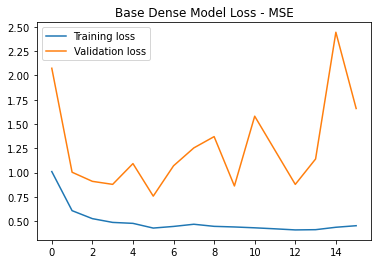

In [23]:
resultsDF = modelFit(trainX,trainY,testX,testY,modelDense0,200,2,[early_stopping],"Base Dense Model",resultsDF)

In [24]:
resultsDF

,Model,Type,Epochs,BatchSize,MSE
0,Base Dense Model,train Set,200,2,0.460565
1,Base Dense Model,Test Set,200,2,1.659461


predicting clicks using test dataset...
MAE train: 15481.705, MAE test: 7317.204


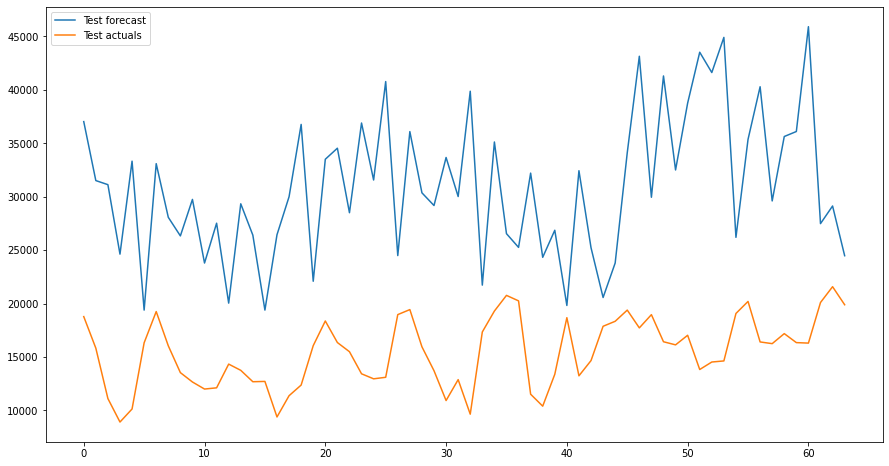

In [25]:
n_future2 = 30
makePredictions2(trainX,testX,trainY,testY,modelDense0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

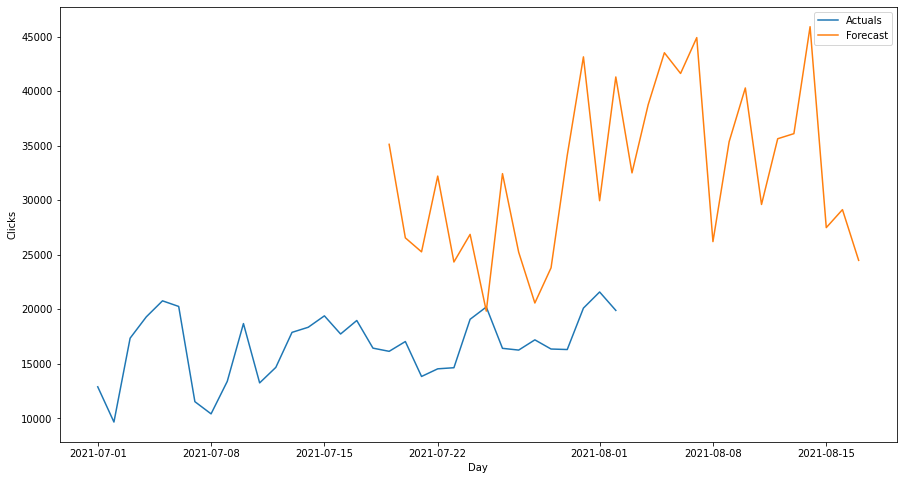

In [26]:
makeFuturePredictions(modelDense0,n_future2,trainX2,train_dates,scaler,df)

## Multi-Dense Model

In [27]:
modelMD = keras.Sequential()
modelMD.add(layers.Dense(32, activation="relu", input_shape=(trainX.shape[1],trainX.shape[2])))
modelMD.add(layers.Dense(32, activation="relu"))
modelMD.add(layers.Flatten())
modelMD.add(layers.Dense(1))
modelMD.compile(optimizer='adam', loss='mse')
modelMD.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 30, 32)            640       
                                                                 
 dense_2 (Dense)             (None, 30, 32)            1056      
                                                                 
 flatten_1 (Flatten)         (None, 960)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 961       
                                                                 
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
404/404 [==============================] - 1s 3ms/step - loss: 0.5895 - val_loss: 0.5277
Epoch 2/200
404/404 [==============================] - 1s 2ms/step - loss: 0.3047 - val_loss: 0.3920
Epoch 3/200
404/404 [==============================] - 1s 2ms/step - loss: 0.2547 - val_loss: 0.4665
Epoch 4/200
404/404 [==============================] - 1s 2ms/step - loss: 0.1953 - val_loss: 0.2251
Epoch 5/200
404/404 [==============================] - 1s 2ms/step - loss: 0.1647 - val_loss: 0.3136
Epoch 6/200
404/404 [==============================] - 1s 2ms/step - loss: 0.1552 - val_loss: 0.2712
Epoch 7/200
404/404 [==============================] - 1s 2ms/step - loss: 0.1611 - val_loss: 0.2997
Epoch 8/200
404/404 [==============================] - 1s 2ms/step - loss: 0.1490 - val_loss: 0.1605
Epoch 9/200
404/404 [==============================] - 1s 2ms/step - loss: 0.1390 - val_loss: 0.1350
Epoch 10/200
404/404 [==============================] - 1s 2ms/step - loss: 0.1150 - val_lo

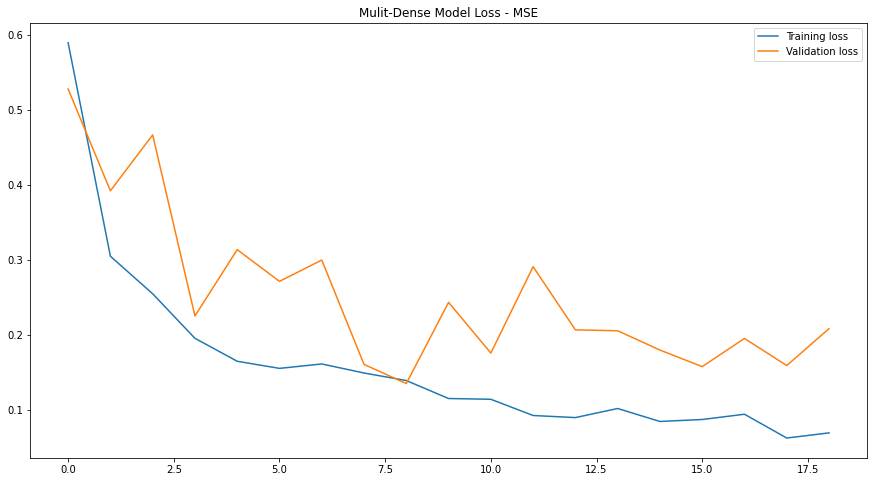

In [28]:
resultsDF = modelFit(trainX,trainY,testX,testY,modelMD,200,2,[early_stopping],"Mulit-Dense Model",resultsDF)

In [29]:
resultsDF

,Model,Type,Epochs,BatchSize,MSE
0,Base Dense Model,train Set,200,2,0.460565
1,Base Dense Model,Test Set,200,2,1.659461
2,Mulit-Dense Model,train Set,200,2,0.086212
3,Mulit-Dense Model,Test Set,200,2,0.208241


predicting clicks using test dataset...
MAE train: 5139.681, MAE test: 2848.317


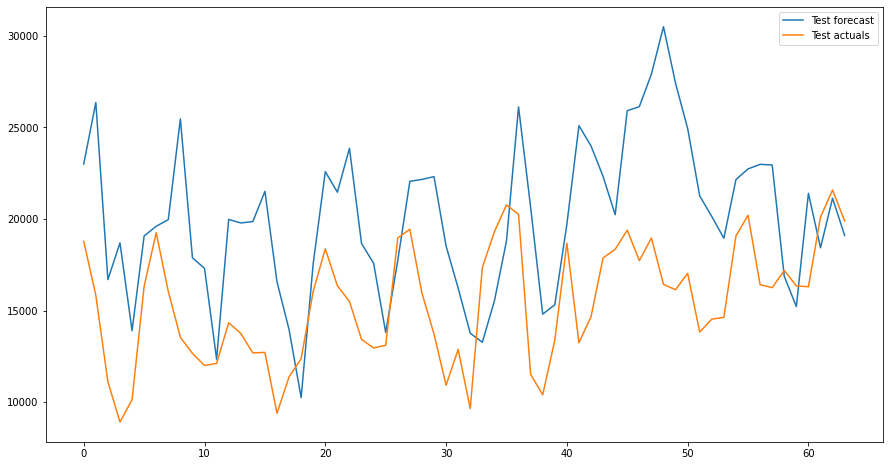

In [30]:
n_future2 = 30
makePredictions2(trainX,testX,trainY,testY,modelMD)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

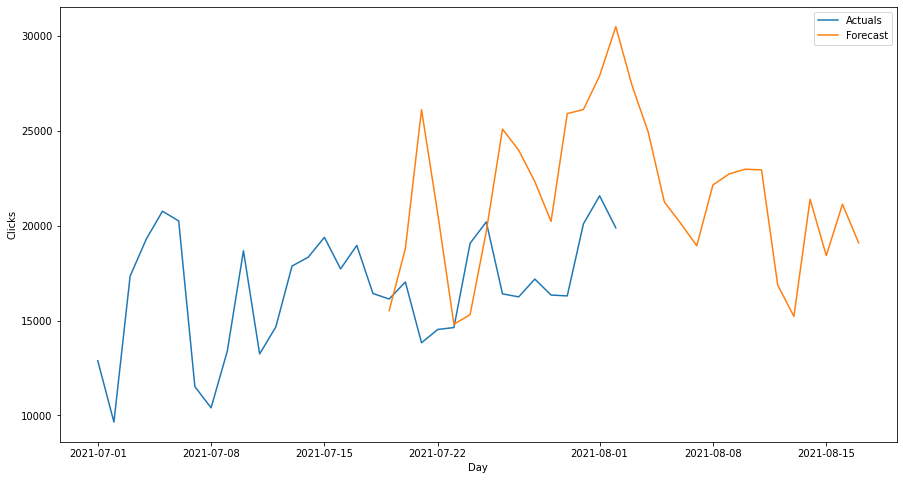

In [31]:
makeFuturePredictions(modelMD,n_future2,trainX2,train_dates,scaler,df)

## Vanilla LSTM

In [32]:
Vmodel = Sequential()
Vmodel.add(LSTM(50, activation='relu', input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=False))
Vmodel.add(Dense(1))
Vmodel.compile(optimizer='adam', loss='mse')
Vmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                14000     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14,051
Trainable params: 14,051
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
404/404 [==============================] - 5s 9ms/step - loss: 0.3601 - val_loss: 0.0564
Epoch 2/200
404/404 [==============================] - 4s 9ms/step - loss: 0.2715 - val_loss: 0.0465
Epoch 3/200
404/404 [==============================] - 4s 9ms/step - loss: 0.2404 - val_loss: 0.0292
Epoch 4/200
404/404 [==============================] - 4s 9ms/step - loss: 0.1939 - val_loss: 0.0344
Epoch 5/200
404/404 [==============================] - 4s 9ms/step - loss: 0.1591 - val_loss: 0.0348
Epoch 6/200
404/404 [==============================] - 4s 9ms/step - loss: 0.1307 - val_loss: 0.0346
Epoch 7/200
404/404 [==============================] - 4s 9ms/step - loss: 0.1202 - val_loss: 0.0414
Epoch 8/200
404/404 [==============================] - 4s 9ms/step - loss: 0.0990 - val_loss: 0.0461
Epoch 9/200
404/404 [==============================] - 4s 9ms/step - loss: 0.0899 - val_loss: 0.0326
Epoch 10/200
404/404 [==============================] - 4s 10ms/step - loss: 0.0926 - val_l

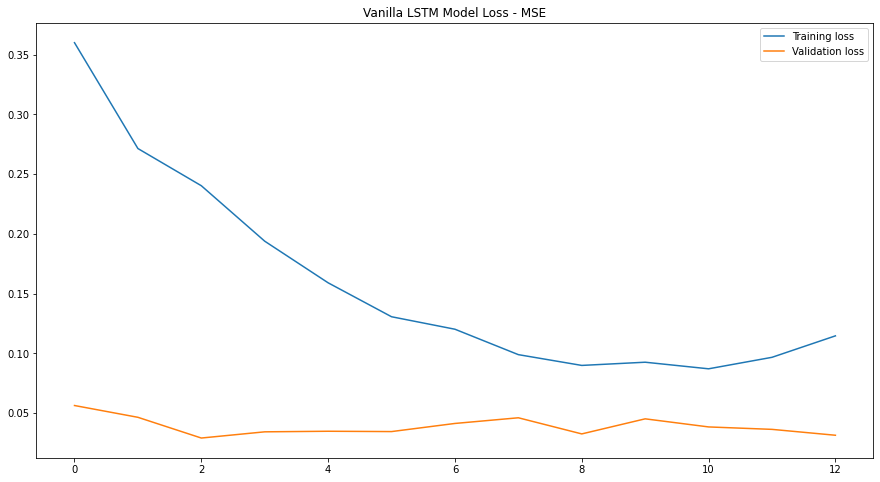

In [33]:
resultsDF = modelFit(trainX,trainY,testX,testY,Vmodel,200,2,[early_stopping],"Vanilla LSTM Model",resultsDF)

In [34]:
resultsDF

,Model,Type,Epochs,BatchSize,MSE
0,Base Dense Model,train Set,200,2,0.460565
1,Base Dense Model,Test Set,200,2,1.659461
2,Mulit-Dense Model,train Set,200,2,0.086212
3,Mulit-Dense Model,Test Set,200,2,0.208241
4,Vanilla LSTM Model,train Set,200,2,0.089296
5,Vanilla LSTM Model,Test Set,200,2,0.031494


predicting clicks using test dataset...
MAE train: 1799.144, MAE test: 2243.365


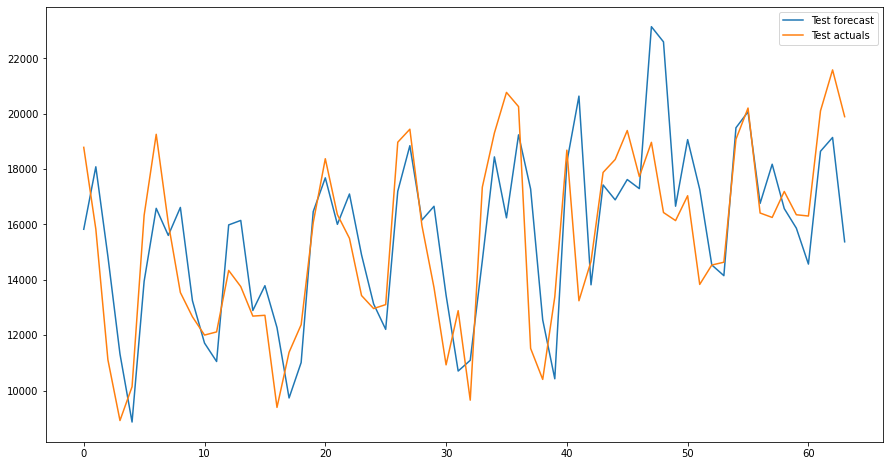

In [35]:

makePredictions2(trainX,testX,trainY,testY,Vmodel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

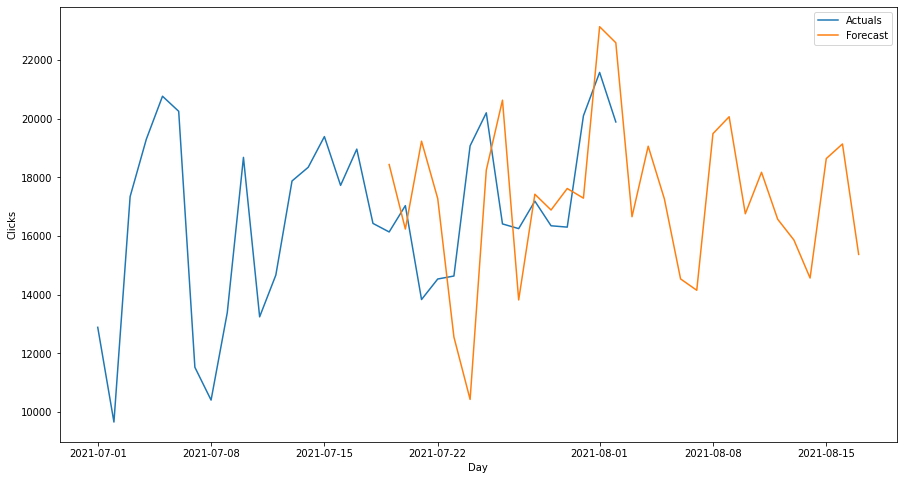

In [36]:
makeFuturePredictions(Vmodel,n_future2,trainX2,train_dates,scaler,df)

## LSTM Model

In [37]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(25, activation='relu',return_sequences=True))
model.add(LSTM(25, activation='relu',return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 50)            14000     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 25)            7600      
                                                                 
 lstm_3 (LSTM)               (None, 25)                5100      
                                                                 
 dense_5 (Dense)             (None, 25)                650       
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 27,376
Trainable params: 27,376
Non-trai

Epoch 1/200
404/404 [==============================] - 12s 24ms/step - loss: 1.5491 - val_loss: 0.2318
Epoch 2/200
404/404 [==============================] - 9s 23ms/step - loss: 0.6784 - val_loss: 0.1286
Epoch 3/200
404/404 [==============================] - 10s 24ms/step - loss: 0.6110 - val_loss: 0.0959
Epoch 4/200
404/404 [==============================] - 10s 24ms/step - loss: 0.5916 - val_loss: 0.1189
Epoch 5/200
404/404 [==============================] - 10s 24ms/step - loss: 0.4752 - val_loss: 0.0968
Epoch 6/200
404/404 [==============================] - 10s 24ms/step - loss: 0.4418 - val_loss: 0.0678
Epoch 7/200
404/404 [==============================] - 9s 23ms/step - loss: 0.4508 - val_loss: 0.0672
Epoch 8/200
404/404 [==============================] - 9s 23ms/step - loss: 0.4402 - val_loss: 0.0752
Epoch 9/200
404/404 [==============================] - 9s 23ms/step - loss: 0.3909 - val_loss: 0.0723
Epoch 10/200
404/404 [==============================] - 9s 23ms/step - loss: 

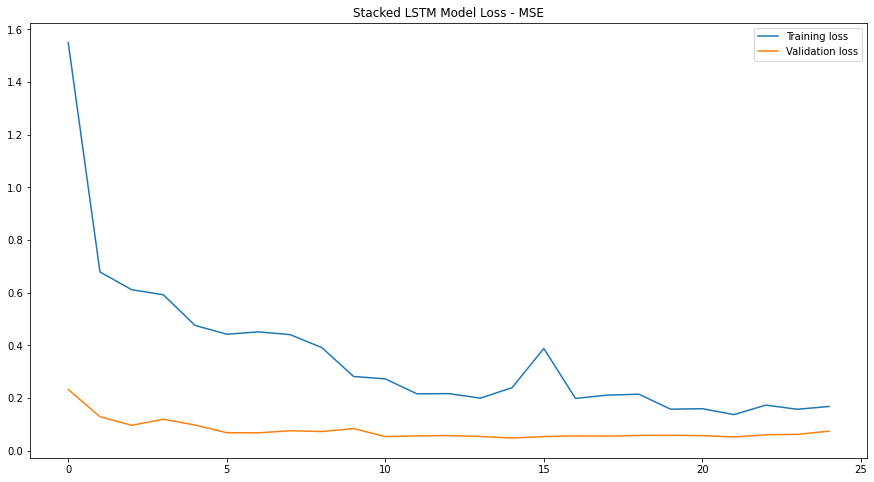

In [38]:
resultsDF = modelFit(trainX,trainY,testX,testY,model,200,2,[early_stopping],"Stacked LSTM Model",resultsDF)

In [39]:
resultsDF

,Model,Type,Epochs,BatchSize,MSE
0,Base Dense Model,train Set,200,2,0.460565
1,Base Dense Model,Test Set,200,2,1.659461
2,Mulit-Dense Model,train Set,200,2,0.086212
3,Mulit-Dense Model,Test Set,200,2,0.208241
4,Vanilla LSTM Model,train Set,200,2,0.089296
5,Vanilla LSTM Model,Test Set,200,2,0.031494
6,Stacked LSTM Model,train Set,200,2,0.118935
7,Stacked LSTM Model,Test Set,200,2,0.073738


predicting clicks using test dataset...
MAE train: 2845.543, MAE test: 2662.901


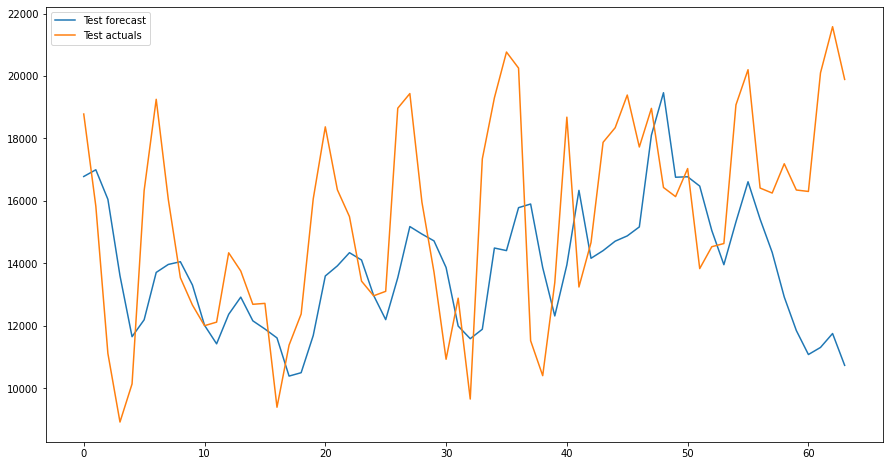

In [40]:
makePredictions2(trainX,testX,trainY,testY,model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

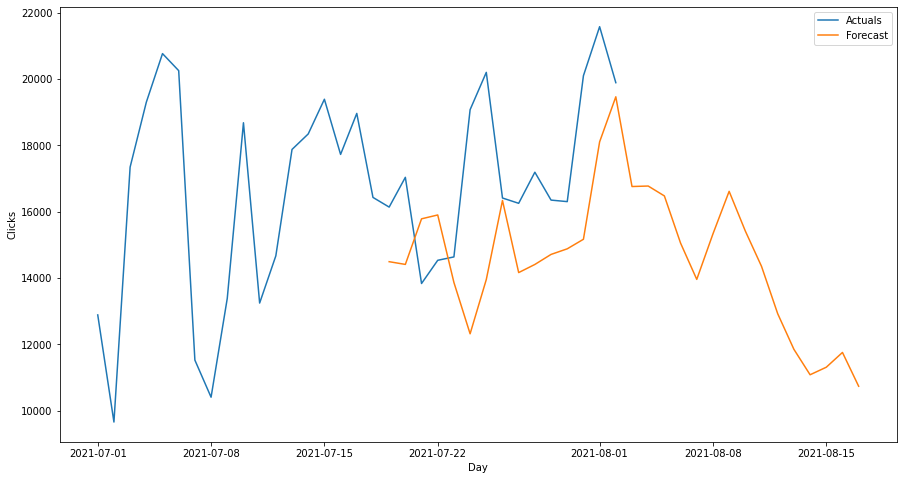

In [41]:
makeFuturePredictions(model,n_future2,trainX2,train_dates,scaler,df)

## Bidirectional LSTM

In [42]:
modelBD = Sequential()
modelBD.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(trainX.shape[1],trainX.shape[2])))
modelBD.add(Dense(1))
modelBD.compile(optimizer='adam', loss='mse')
modelBD.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              28000     
 l)                                                              
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 28,101
Trainable params: 28,101
Non-trainable params: 0
_________________________________________________________________


Epoch 1/200
404/404 [==============================] - 8s 15ms/step - loss: 0.4856 - val_loss: 0.0751
Epoch 2/200
404/404 [==============================] - 6s 15ms/step - loss: 0.2645 - val_loss: 0.0668
Epoch 3/200
404/404 [==============================] - 6s 15ms/step - loss: 0.2030 - val_loss: 0.0532
Epoch 4/200
404/404 [==============================] - 6s 15ms/step - loss: 0.1834 - val_loss: 0.0802
Epoch 5/200
404/404 [==============================] - 6s 15ms/step - loss: 0.2175 - val_loss: 0.0421
Epoch 6/200
404/404 [==============================] - 6s 15ms/step - loss: 0.1646 - val_loss: 0.0408
Epoch 7/200
404/404 [==============================] - 6s 15ms/step - loss: 0.1507 - val_loss: 0.0435
Epoch 8/200
404/404 [==============================] - 6s 15ms/step - loss: 0.1177 - val_loss: 0.0466
Epoch 9/200
404/404 [==============================] - 6s 15ms/step - loss: 0.0996 - val_loss: 0.0595
Epoch 10/200
404/404 [==============================] - 6s 14ms/step - loss: 0.085

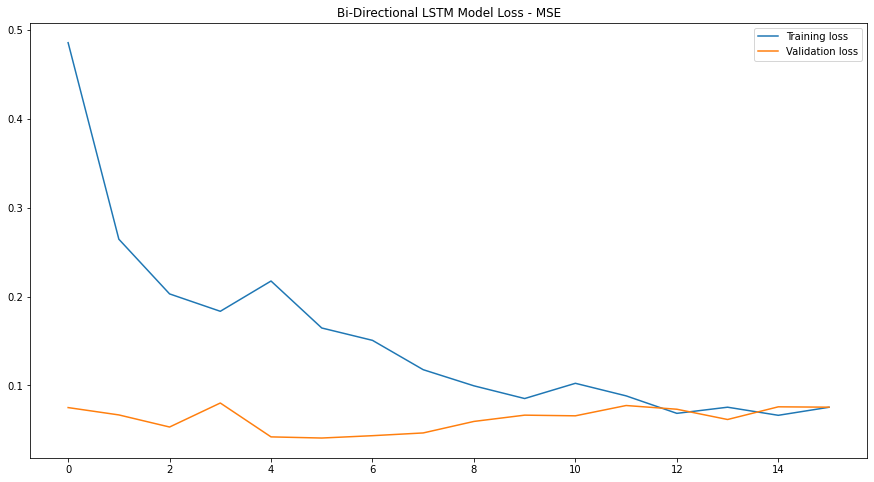

In [43]:
resultsDF = modelFit(trainX,trainY,testX,testY,modelBD,200,2,[early_stopping],"Bi-Directional LSTM Model",resultsDF)

In [44]:
resultsDF

,Model,Type,Epochs,BatchSize,MSE
0,Base Dense Model,train Set,200,2,0.460565
1,Base Dense Model,Test Set,200,2,1.659461
2,Mulit-Dense Model,train Set,200,2,0.086212
3,Mulit-Dense Model,Test Set,200,2,0.208241
4,Vanilla LSTM Model,train Set,200,2,0.089296
5,Vanilla LSTM Model,Test Set,200,2,0.031494
6,Stacked LSTM Model,train Set,200,2,0.118935
7,Stacked LSTM Model,Test Set,200,2,0.073738
8,Bi-Directional LSTM Model,train Set,200,2,0.053273
9,Bi-Directional LSTM Model,Test Set,200,2,0.075537


predicting clicks using test dataset...
MAE train: 2864.725, MAE test: 1959.085


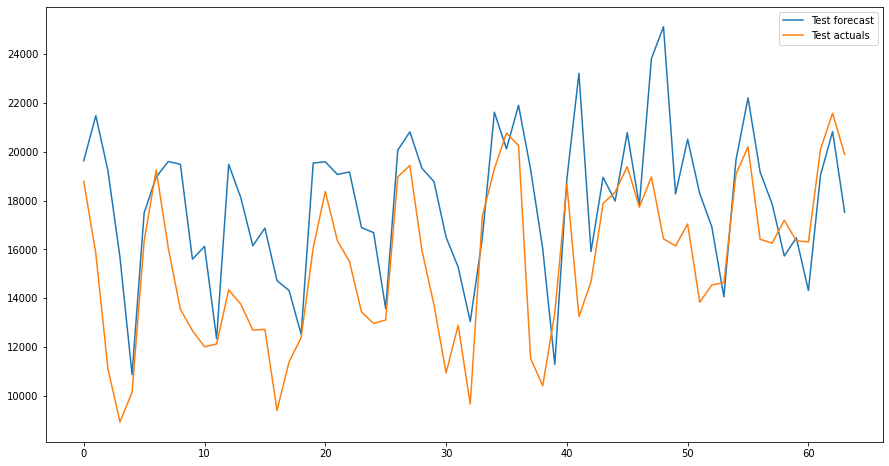

In [45]:

makePredictions2(trainX,testX,trainY,testY,modelBD)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpret

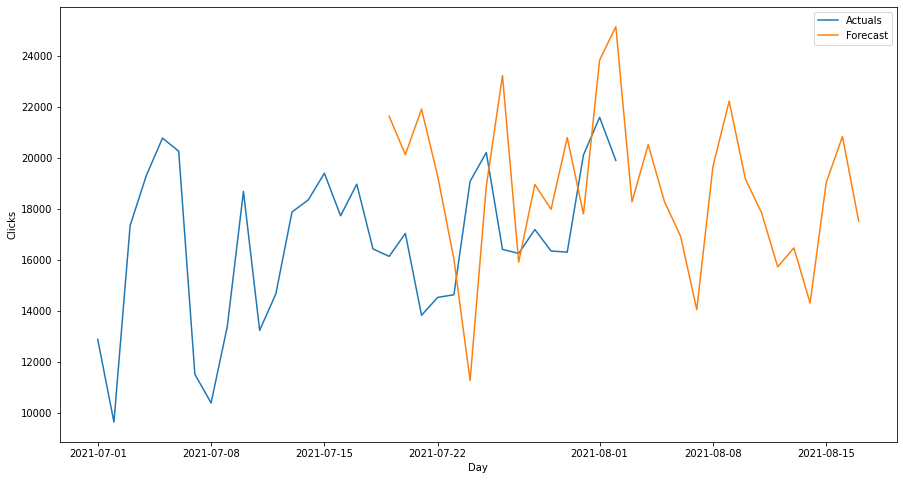

In [46]:
makeFuturePredictions(modelBD,n_future2,trainX2,train_dates,scaler,df)

# Model Selection

Stacked LTSM & Bi-directional LSTM have proven to be the best models with the lowest MSE. 

In [47]:
resultsDF

,Model,Type,Epochs,BatchSize,MSE
0,Base Dense Model,train Set,200,2,0.460565
1,Base Dense Model,Test Set,200,2,1.659461
2,Mulit-Dense Model,train Set,200,2,0.086212
3,Mulit-Dense Model,Test Set,200,2,0.208241
4,Vanilla LSTM Model,train Set,200,2,0.089296
5,Vanilla LSTM Model,Test Set,200,2,0.031494
6,Stacked LSTM Model,train Set,200,2,0.118935
7,Stacked LSTM Model,Test Set,200,2,0.073738
8,Bi-Directional LSTM Model,train Set,200,2,0.053273
9,Bi-Directional LSTM Model,Test Set,200,2,0.075537


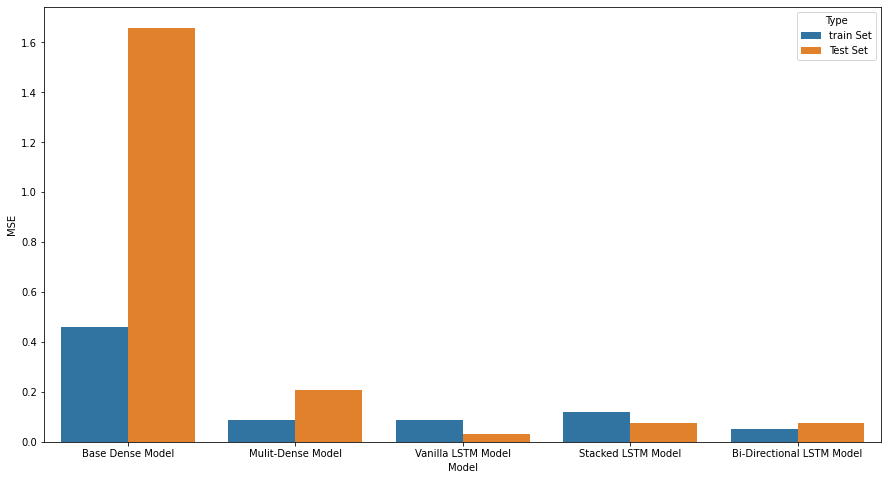

In [48]:
sns.barplot(x = 'Model', y = 'MSE', data = resultsDF,hue='Type')

Further research required around feature engineering and hyperparameter tuning.